In [1]:
# Testing out validation code in python notebook
## IMPORT REQUIREMENTS

from matplotlib import pyplot as plt
import numpy as np
from scipy import optimize
from multiprocessing import Process
from json import dump

from absorptive_experiment_misc.definitions import *
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import DENSITY_MATRIX_FORMALISM



In [2]:

## SIMULATION SETUP
# visibility at fringe bottom: .01 * .01 * .25/4
params = {
    "QUANTUM_WAVELENGTH" : 1536.,
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.015,  # mean photon number of SPDC source on node 1
    "MPN_SETTINGS": [0.001, 0.004, 0.008, 0.012, 0.016, 0.02],

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.2, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.2,  # efficiency of detector 2 of BSM
    # "DET_EFF_SETTINGS": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20,
    "SIGNAL_DET_DEAD" : 6000,
    "IDLER_DET_DEAD" : 6000,

    # fibers
    "SIGNAL_DIST" : 1.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 1.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.,  # attenuation rate of optical fibre (in dB/km)
    'POLARIZATION_FIDELITY': 0.,

    # experiment settings
    "num_bs_trials_per_phase" : 1,
    "phase_settings" : [np.pi],

    "MODE_NUM": 100000,

}


In [3]:
def run_simulations(idler_phase):
    # print("\nNew Idler phase:", idler_phase)
    signal_receiver.reset()
    signal_receiver.rotateIdler(idler_phase)
    for signal_phase in params["phase_settings"]:
        timeline.init()
        # print("New Signal phase:", signal_phase, "(Idler:", idler_phase, ")")
        signal_receiver.rotateSignal(signal_phase)
        source_node.start()
        timeline.run()

    new_signal_singles, new_idler_singles, new_coincidences = signal_receiver.get_data()
    # return new_coincidences[0], new_coincidences[1]
    return new_coincidences[0]

iter: 0 mpn: 0.001
iter: 1 mpn: 0.001
iter: 2 mpn: 0.001
iter: 3 mpn: 0.001
iter: 4 mpn: 0.001
iter: 5 mpn: 0.001
iter: 6 mpn: 0.001
iter: 7 mpn: 0.001
iter: 8 mpn: 0.001
iter: 9 mpn: 0.001
iter: 10 mpn: 0.001
iter: 11 mpn: 0.001
iter: 12 mpn: 0.001
iter: 13 mpn: 0.001
iter: 14 mpn: 0.001
iter: 15 mpn: 0.001
iter: 16 mpn: 0.001
iter: 17 mpn: 0.001
iter: 18 mpn: 0.001
iter: 19 mpn: 0.001
iter: 20 mpn: 0.001
iter: 21 mpn: 0.001
iter: 22 mpn: 0.001
iter: 23 mpn: 0.001
iter: 24 mpn: 0.001
iter: 25 mpn: 0.001
iter: 26 mpn: 0.001
iter: 27 mpn: 0.001
iter: 28 mpn: 0.001
iter: 29 mpn: 0.001
iter: 30 mpn: 0.001
iter: 31 mpn: 0.001
iter: 32 mpn: 0.001
iter: 33 mpn: 0.001
iter: 34 mpn: 0.001
iter: 35 mpn: 0.001
iter: 36 mpn: 0.001
iter: 37 mpn: 0.001
iter: 38 mpn: 0.001
iter: 39 mpn: 0.001
iter: 40 mpn: 0.001
iter: 41 mpn: 0.001
iter: 42 mpn: 0.001
iter: 43 mpn: 0.001
iter: 44 mpn: 0.001
iter: 45 mpn: 0.001
iter: 46 mpn: 0.001
iter: 47 mpn: 0.001
iter: 48 mpn: 0.001
iter: 49 mpn: 0.001
iter: 50 m

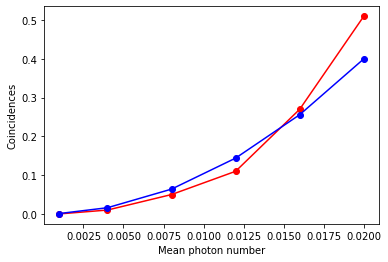

In [4]:

coincidences = []
idler_singles = []
signal_singles = []
# coinc_fringe_top = []
coinc_fringe_bottom = []

for mpn in params["MPN_SETTINGS"]:
    
    timeline = Timeline(2e12, formalism=DENSITY_MATRIX_FORMALISM)


    ## NETWORK SETUP

    signal_receiver_name = "signal_receiver"
    idler_receiver_name = "idler_receiver"
    signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
    idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

    source_node_name = "Polariation_source_node"
    source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

    qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
    qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

    source_node.set_source_mpn(mpn)
    coinc_fringe_bottom_sum = 0
    # local_singles_idler = 0
    # local_singles_signal = 0
    # local_rejects_idler = 0
    # local_rejects_signal = 0
    num_iterations = 100
    for iter in range(num_iterations):
        print("iter:", iter, "mpn:", mpn)
        coinc_fringe_bottom_sum += run_simulations(idler_phase=0)
        # print("singles_a sum:", signal_receiver.singles_a, "singles_b sum:", signal_receiver.singles_b, "rejects:", signal_receiver.rejects)
        # local_singles_idler += signal_receiver.singles_idler
        # local_singles_signal += signal_receiver.singles_signal
        
        # local_rejects_idler += signal_receiver.rejects_idler
        # local_rejects_signal += signal_receiver.rejects_signal

        # signal_receiver.rejects_signal = 0
        # signal_receiver.rejects_idler = 0
        
        # signal_receiver.singles_idler = 0
        # signal_receiver.singles_signal = 0
    # print("avg local_singles_signal:", local_singles_signal/1, "avg local_singles_idler:", local_singles_idler/1)
    # print("avg local_rejects_signal:", local_rejects_signal/1, "avg local_rejects_idler:", local_rejects_idler/1)
    # coinc_fringe_top_trial, coinc_fringe_bottom_trial = run_simulations(idler_phase=0)
    # coinc_fringe_top.append(coinc_fringe_top_trial)
    coinc_fringe_bottom.append(coinc_fringe_bottom_sum/num_iterations)
    print("fringe bottom:", coinc_fringe_bottom_sum/num_iterations, "expected bottom:", params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn**2)/4)

exp_coinc_fringe_top = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn/2 + (mpn**2)/4) for mpn in params["MPN_SETTINGS"]]
exp_coinc_fringe_bottom = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn**2)/4 for mpn in params["MPN_SETTINGS"]]

# plt.figure()

# plt.plot(coinc_fringe_top)
# plt.plot(exp_coinc_fringe_top)


plt.figure()
plt.plot(params["MPN_SETTINGS"], coinc_fringe_bottom, 'r-o')
plt.plot(params["MPN_SETTINGS"], exp_coinc_fringe_bottom, 'b-o')
plt.xlabel("Mean photon number")
plt.ylabel("Coincidences")


print("coinc_fringe_bottom:", coinc_fringe_bottom)
print("exp_coinc_fringe_top:", exp_coinc_fringe_bottom)
    

iter: 0 mpn: 0.01
iter: 1 mpn: 0.01
iter: 2 mpn: 0.01
iter: 3 mpn: 0.01
iter: 4 mpn: 0.01
iter: 5 mpn: 0.01
iter: 6 mpn: 0.01
iter: 7 mpn: 0.01
iter: 8 mpn: 0.01
iter: 9 mpn: 0.01
iter: 10 mpn: 0.01
iter: 11 mpn: 0.01
iter: 12 mpn: 0.01
iter: 13 mpn: 0.01
iter: 14 mpn: 0.01
iter: 15 mpn: 0.01
iter: 16 mpn: 0.01
iter: 17 mpn: 0.01
iter: 18 mpn: 0.01
iter: 19 mpn: 0.01
iter: 20 mpn: 0.01
iter: 21 mpn: 0.01
iter: 22 mpn: 0.01
iter: 23 mpn: 0.01
iter: 24 mpn: 0.01
iter: 25 mpn: 0.01
iter: 26 mpn: 0.01
iter: 27 mpn: 0.01
iter: 28 mpn: 0.01
iter: 29 mpn: 0.01
iter: 30 mpn: 0.01
iter: 31 mpn: 0.01
iter: 32 mpn: 0.01
iter: 33 mpn: 0.01
iter: 34 mpn: 0.01
iter: 35 mpn: 0.01
iter: 36 mpn: 0.01
iter: 37 mpn: 0.01
iter: 38 mpn: 0.01
iter: 39 mpn: 0.01
iter: 40 mpn: 0.01
iter: 41 mpn: 0.01
iter: 42 mpn: 0.01
iter: 43 mpn: 0.01
iter: 44 mpn: 0.01
iter: 45 mpn: 0.01
iter: 46 mpn: 0.01
iter: 47 mpn: 0.01
iter: 48 mpn: 0.01
iter: 49 mpn: 0.01
iter: 50 mpn: 0.01
iter: 51 mpn: 0.01
iter: 52 mpn: 0.01
ite

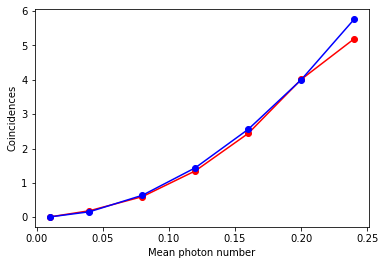

In [4]:

coincidences = []
idler_singles = []
signal_singles = []
coinc_fringe_bottom = []

for mpn in params["MPN_SETTINGS"]:
    
    timeline = Timeline(2e12, formalism=DENSITY_MATRIX_FORMALISM)

    signal_receiver_name = "signal_receiver"
    idler_receiver_name = "idler_receiver"
    signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
    idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

    source_node_name = "Polariation_source_node"
    source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

    qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
    qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

    source_node.set_source_mpn(mpn)
    coinc_fringe_bottom_sum = 0
    num_iterations = 100
    for iter in range(num_iterations):
        print("iter:", iter, "mpn:", mpn)
        coinc_fringe_bottom_sum += run_simulations(idler_phase=0)
    coinc_fringe_bottom.append(coinc_fringe_bottom_sum/num_iterations)
    print("fringe bottom:", coinc_fringe_bottom_sum/num_iterations, "expected bottom:", params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn**2)/4)

exp_coinc_fringe_top = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn/2 + (mpn**2)/4) for mpn in params["MPN_SETTINGS"]]
exp_coinc_fringe_bottom = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn**2)/4 for mpn in params["MPN_SETTINGS"]]

plt.figure()
plt.plot(params["MPN_SETTINGS"], coinc_fringe_bottom, 'r-o')
plt.plot(params["MPN_SETTINGS"], exp_coinc_fringe_bottom, 'b-o')
plt.xlabel("Mean photon number")
plt.ylabel("Coincidences")


print("coinc_fringe_bottom:", coinc_fringe_bottom)
print("exp_coinc_fringe_top:", exp_coinc_fringe_bottom)
    

iter: 0 alpha: 0.2
iter: 1 alpha: 0.2
iter: 2 alpha: 0.2
iter: 3 alpha: 0.2
iter: 4 alpha: 0.2
iter: 5 alpha: 0.2
iter: 6 alpha: 0.2
iter: 7 alpha: 0.2
iter: 8 alpha: 0.2
iter: 9 alpha: 0.2
iter: 10 alpha: 0.2
iter: 11 alpha: 0.2
iter: 12 alpha: 0.2
iter: 13 alpha: 0.2
iter: 14 alpha: 0.2
iter: 15 alpha: 0.2
iter: 16 alpha: 0.2
iter: 17 alpha: 0.2
iter: 18 alpha: 0.2
iter: 19 alpha: 0.2
iter: 20 alpha: 0.2
iter: 21 alpha: 0.2
iter: 22 alpha: 0.2
iter: 23 alpha: 0.2
iter: 24 alpha: 0.2
iter: 25 alpha: 0.2
iter: 26 alpha: 0.2
iter: 27 alpha: 0.2
iter: 28 alpha: 0.2
iter: 29 alpha: 0.2
iter: 30 alpha: 0.2
iter: 31 alpha: 0.2
iter: 32 alpha: 0.2
iter: 33 alpha: 0.2
iter: 34 alpha: 0.2
iter: 35 alpha: 0.2
iter: 36 alpha: 0.2
iter: 37 alpha: 0.2
iter: 38 alpha: 0.2
iter: 39 alpha: 0.2
iter: 40 alpha: 0.2
iter: 41 alpha: 0.2
iter: 42 alpha: 0.2
iter: 43 alpha: 0.2
iter: 44 alpha: 0.2
iter: 45 alpha: 0.2
iter: 46 alpha: 0.2
iter: 47 alpha: 0.2
iter: 48 alpha: 0.2
iter: 49 alpha: 0.2
iter: 50 a

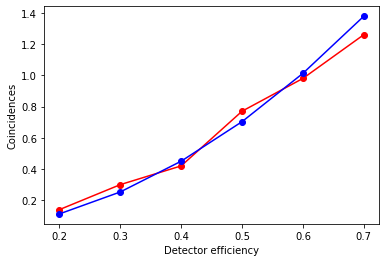

In [4]:

coincidences = []
idler_singles = []
signal_singles = []
coinc_fringe_bottom = []

for alpha in params["DET_EFF_SETTINGS"]:
    
    timeline = Timeline(2e12, formalism=DENSITY_MATRIX_FORMALISM)

    signal_receiver_name = "signal_receiver"
    idler_receiver_name = "idler_receiver"
    signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
    idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

    source_node_name = "Polariation_source_node"
    source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

    qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
    qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

    signal_receiver.set_det_eff(alpha)
    coinc_fringe_bottom_sum = 0
    num_iterations = 100
    for iter in range(num_iterations):
        print("iter:", iter, "alpha:", alpha)
        coinc_fringe_bottom_sum += run_simulations(idler_phase=0)
    coinc_fringe_bottom.append(coinc_fringe_bottom_sum/num_iterations)
    print("fringe bottom:", coinc_fringe_bottom_sum/num_iterations, "expected bottom:", params["MODE_NUM"] * (alpha**2)*(params["MEAN_PHOTON_NUM"]**2)/4)

# exp_coinc_fringe_top = [params["MODE_NUM"] * (alpha**2)*(params["MEAN_PHOTON_NUM"]/2 + (params["MEAN_PHOTON_NUM"]**2)/4) for alpha in params["EFF_SETTINGS"]]
exp_coinc_fringe_bottom = [params["MODE_NUM"] * (alpha**2)*(params["MEAN_PHOTON_NUM"]**2)/4 for alpha in params["DET_EFF_SETTINGS"]]

plt.figure()
plt.plot(params["DET_EFF_SETTINGS"], coinc_fringe_bottom, 'r-o')
plt.plot(params["DET_EFF_SETTINGS"], exp_coinc_fringe_bottom, 'b-o')
plt.xlabel("Detector efficiency")
plt.ylabel("Coincidences")


print("coinc_fringe_bottom:", coinc_fringe_bottom)
print("exp_coinc_fringe_top:", exp_coinc_fringe_bottom)
    